1. Выберите ряд из первого задания.
2. Постройте его модель GARCH.
3. Оформите отчёт в Jupyter-ноутбук.

In [1]:
import pandas as pd
import numpy as np
import tqdm
import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
from arch import arch_model
import arch

import matplotlib.pyplot as plt
%matplotlib inline

import io, pickle, zipfile
from zipfile import ZipFile

import warnings
warnings.filterwarnings("ignore")

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [4]:
with ZipFile('Series.zip', 'r') as myzip:
    for item in myzip.infolist():
        print(f'File Name: {item.filename} ')

File Name: international-airline-passengers.csv 
File Name: mean-monthly-air-temperature-deg.csv 
File Name: monthly-boston-armed-robberies-j.csv 
File Name: monthly-sales-of-company-x-jan-6.csv 
File Name: weekly-closings-of-the-dowjones-.csv 
File Name: daily-total-female-births-in-cal.csv 


In [5]:
with ZipFile('Series.zip', 'r') as myzip:
    myzip.extractall()
    
df = pd.read_csv('international-airline-passengers.csv')   # для модели ARIMA 
int_air_pass = pd.read_csv('international-airline-passengers.csv').iloc[:, 1]  
df1 = pd.read_csv('international-airline-passengers.csv').iloc[:, 1]

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


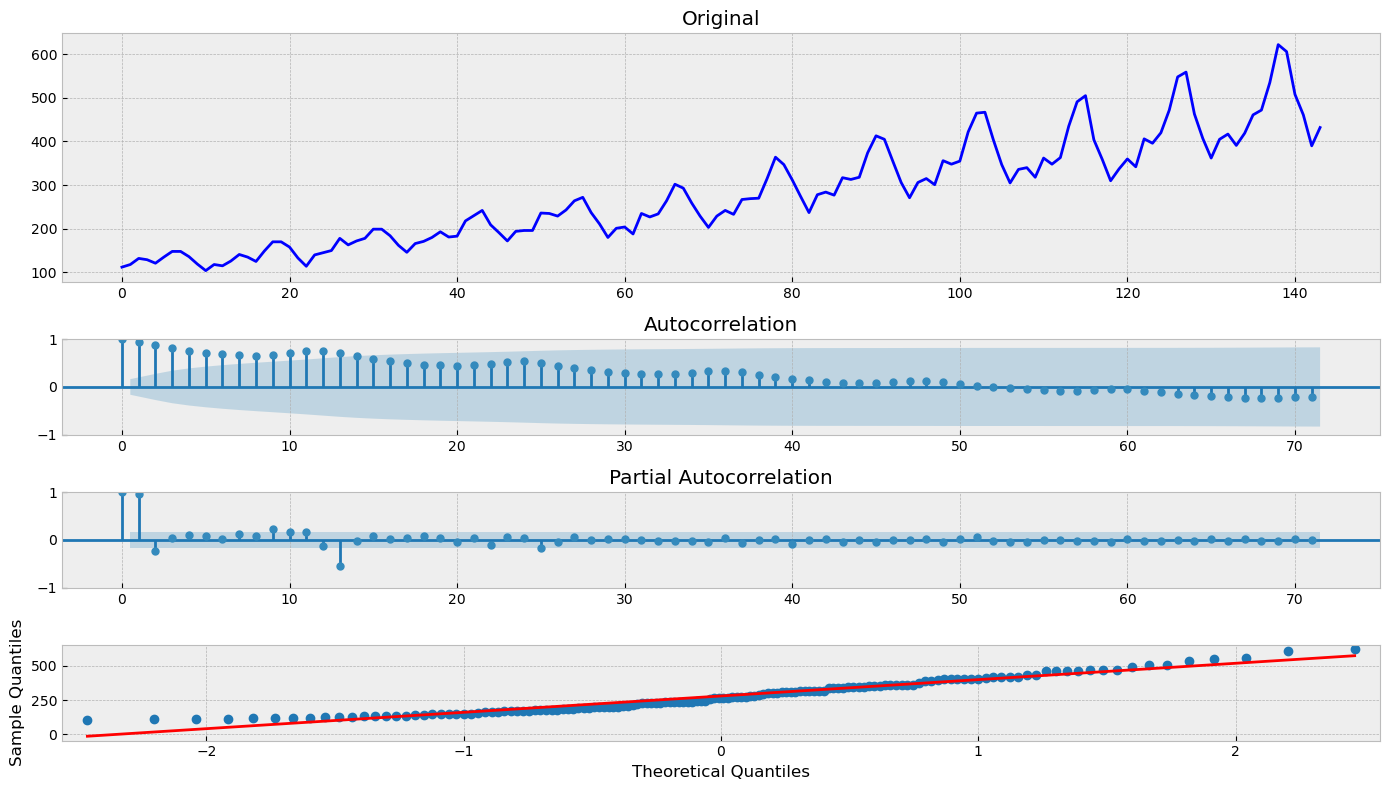

In [6]:
tsplot(int_air_pass, lags = len(int_air_pass)/2 - 1)

Сначала прстроим модель ARIMA, чтобы выявить оптимальные параметры "order"

In [7]:
df['Month'] = pd.to_datetime(df['Month'])

df.set_index('Month', inplace=True)

In [8]:
df

,Count
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [9]:
def search_optimal_sarima(time_series, seasonal_cycle):
    '''
    Для определения параметров модели определим функцию search_optimal_sarima
    
    p — порядок авторегрессии, который описывает количество предыдущих наблюдений,
    принимаемых во внимание в модели. 

    d — порядок интегрирования, который указывает,
    сколько раз нужно взять разность временного ряда для достижения стационарности. 

    q — порядок скользящего среднего, который связан с количеством предыдущих ошибок,
    используемых в модели
    
    P — порядок сезонной авторегрессии, и он основан на количестве предыдущих сезонов,
    которые влияют на текущий сезон.
    
    Для модели SARIMA (ARIMA + сезонность):
    
    D — порядок сезонной интеграции, то есть сколько раз нужно продифференцировать данные,
    чтобы убрать сезонные тренды.

    Q — порядок сезонного скользящего среднего, то есть как много предыдущих сезонных
    ошибок прогноза используется в модели.

    m — это длина сезонного периода. Например, если данные имеют годовую сезонность и
    данные собираются ежемесячно, то m будет равно 12
    '''
    
    order_vals = diff_vals = ma_vals = range(0, 2)
    pdq_combinations = list(itertools.product(order_vals, diff_vals, ma_vals))
    seasonal_combinations = [(combo[0], combo[1], combo[2], seasonal_cycle) for combo in pdq_combinations]
       
    smallest_aic = float("inf")
    optimal_order_param = optimal_seasonal_param = None

    for order_param in pdq_combinations:
        for seasonal_param in seasonal_combinations:
            try:
                sarima_model = sm.tsa.statespace.SARIMAX(time_series,
                                                         order=order_param,
                                                         seasonal_order=seasonal_param,
                                                         enforce_stationarity=False,
                                                         enforce_invertibility=False)

                model_results = sarima_model.fit()
                if model_results.aic < smallest_aic:
                    smallest_aic = model_results.aic
                    optimal_order_param = order_param
                    optimal_seasonal_param = seasonal_param
            except:
                continue

    print('ARIMA{}x{} - AIC:{}'.format(optimal_order_param, optimal_seasonal_param, smallest_aic))


In [10]:
seasonal_cycle_length = 12 # сезонность примем = 12. Логически из контекста и визуально определил

# оптимальные параметры с помощью поиска по сетке
search_optimal_sarima(df, seasonal_cycle_length)

ARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:920.3192974988626


In [11]:
# модель SARIMAX с найденными ранее параметрами

model = SARIMAX(df, order=(0, 1, 1), seasonal_order=(1, 1, 1, 12))

In [12]:
results = model.fit()

In [13]:
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Count   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -506.164
Date:                            Sun, 21 Jul 2024   AIC                           1020.327
Time:                                    19:52:03   BIC                           1031.828
Sample:                                01-01-1949   HQIC                          1025.001
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3441      0.073     -4.701      0.000      -0.487      -0.201
ar.S.L12      -0.9382      0.206   

1. Коэффициенты: они должны быть статистически значимыми. Проверьте p-значения коэффициентов (P>|z|); они должны быть меньше 0.05. 


2. Информационный критерий (AIC): меньшее значение AIC указывает на лучшую подгонку модели.


3. Ljung-Box (L1) (Q): это p-значение для Ljung-Box Q-статистики. Если значение больше 0.05, остатки случайны, что хорошо.


4. Jarque-Bera (JB): это тест на нормальность остатков. Если Prob(JB) больше 0.05, остатки нормальны, что хорошо. 


5. Heteroskedasticity (H): это тест на гетероскедастичность остатков. Если Prob(H) (two-sided) больше 0.05, остатки гетероскедастичны, что хорошо. Гетероскедастичность — это ситуация, когда разброс ошибок ваших прогнозов меняется в зависимости от того, в какой точке вы находитесь. Более простыми словами, это когда у вас имеется неоднородность в ваших данных.

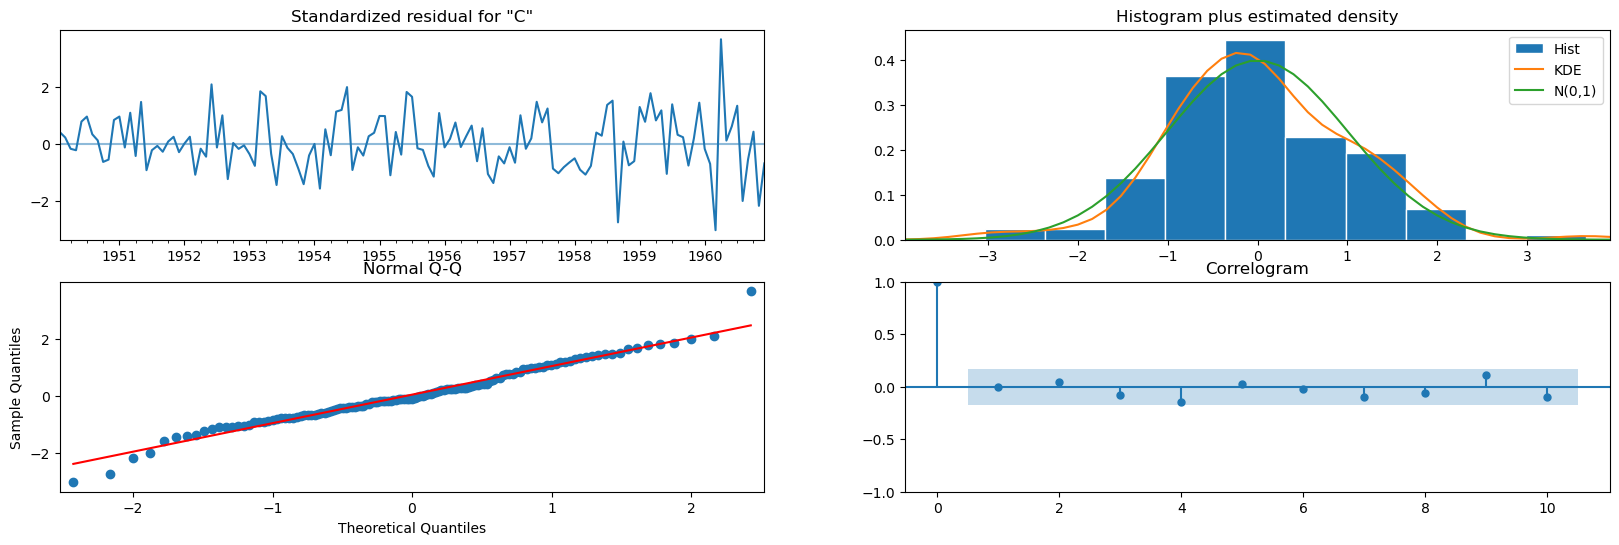

In [14]:
results.plot_diagnostics(figsize=(20, 6))
plt.show()

1. Кривая остатков — это график остатков модели по времени. Если модель хороша, остатки будут случайными, и график будет выглядеть как белый шум. 


2. График нормального квантиля (Q-Q plot) — это график, который сравнивает распределение остатков с идеальным нормальным распределением. Если точки следуют диагональной линии, это означает, что остатки нормально распределены.


3. График коррелограммы — это график автокорреляции остатков. Если модель хороша, остатки не будут коррелировать друг с другом. Отсутствие голубых полосок за пределами голубого диапазона шума указывает на это. 


4. Гистограмма остатков — это гистограмма распределения остатков. Если модель хороша, остатки должны быть нормально распределены, и эта гистограмма будет напоминать форму колокола. 

In [15]:
st_pred = results.get_prediction(start=pd.to_datetime('1954-12-01'), dynamic=False) 
forecast_values = st_pred.predicted_mean

In [16]:
actual_values = df['1955-12-01':]['Count']
forecast_rmse = sqrt(((forecast_values - actual_values)**2).mean())
forecast_mape = np.mean(np.abs((actual_values - forecast_values) / actual_values)) * 100
print(f'RMSE прогноза составляет {round(forecast_rmse, 3)}')
print(f'MAPE прогноза составляет {round(forecast_mape, 3)} %')

RMSE прогноза составляет 13.053
MAPE прогноза составляет 2.57 %


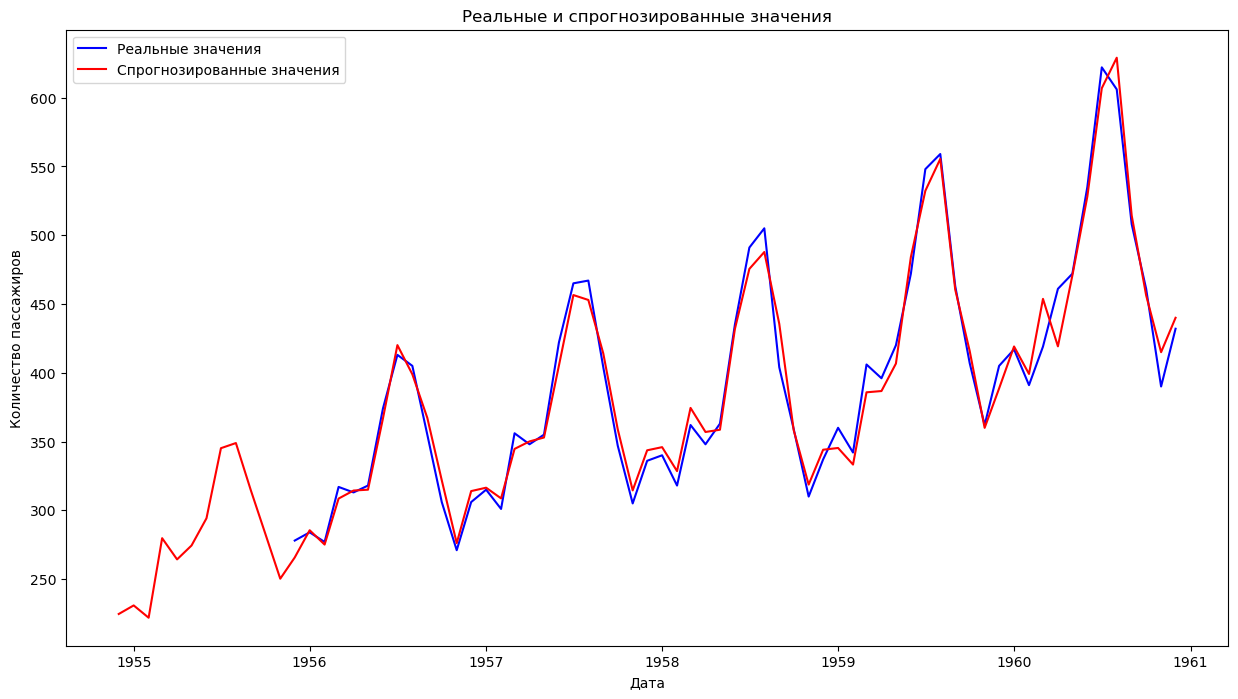

In [17]:
plt.figure(figsize=(15,8))

plt.plot(actual_values.index, actual_values, label='Реальные значения', color='blue')

plt.plot(forecast_values.index, forecast_values, label='Спрогнозированные значения', color='red')

plt.title('Реальные и cпрогнозированные значения')
plt.xlabel('Дата')
plt.ylabel('Количество пассажиров')
plt.legend()

plt.show()

GARCH

In [18]:
int_air_pass = boxcox(int_air_pass, 0)
int_air_pass = int_air_pass[1:] - int_air_pass[:-1]
int_air_pass = int_air_pass[12:] - int_air_pass[:-12]
# приближение ряда к стационарности 

In [19]:
int_air_pass[-5:]

array([-0.04593429,  0.01202388,  0.03183046, -0.05008233, -0.00996401])

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


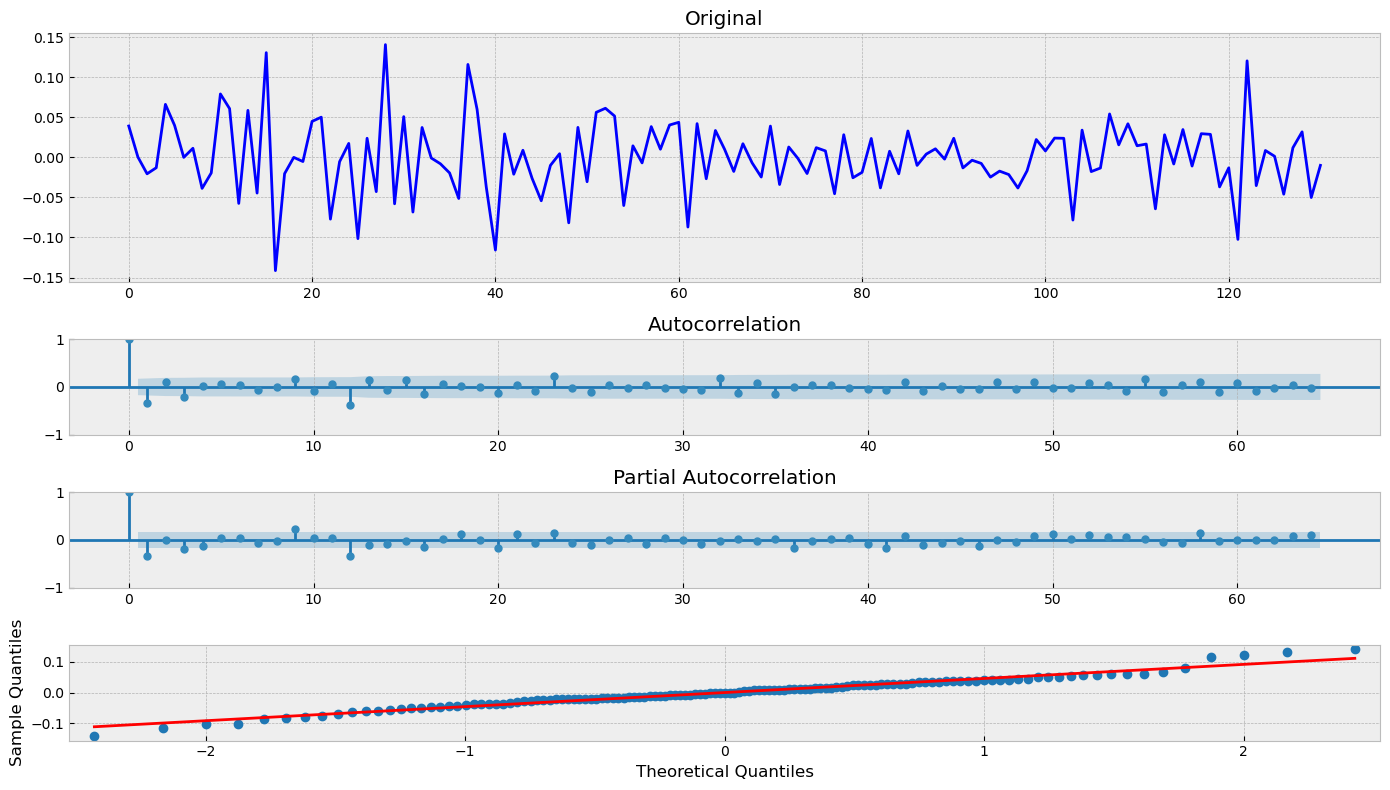

In [20]:
tsplot(int_air_pass, lags = len(int_air_pass)/2 - 1)

In [21]:
# Использование оптимальных параметров, полученных с помощью поиска по сетке
# order=(0, 1, 1)
p = 0
o = 1
q = 1

In [22]:
am = arch_model(int_air_pass, mean='zero', p = 0, o = 1, q = 1, power=2.0, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Zero Mean - GJR-GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.008
Vol Model:                        GJR-GARCH   Log-Likelihood:                224.166
Distribution:      Standardized Student's t   AIC:                          -440.332
Method:                  Maximum Likelihood   BIC:                          -428.831
                                              No. Observations:                  131
Date:                      Sun, Jul 21 2024   Df Residuals:                      131
Time:                              19:52:05   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
o

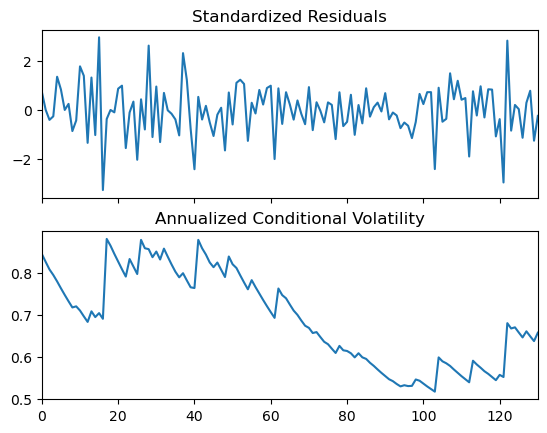

In [23]:
fig = res.plot(annualize='D')
plt.show()
# визуализация стандартизированных дисперсионных остатков 

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


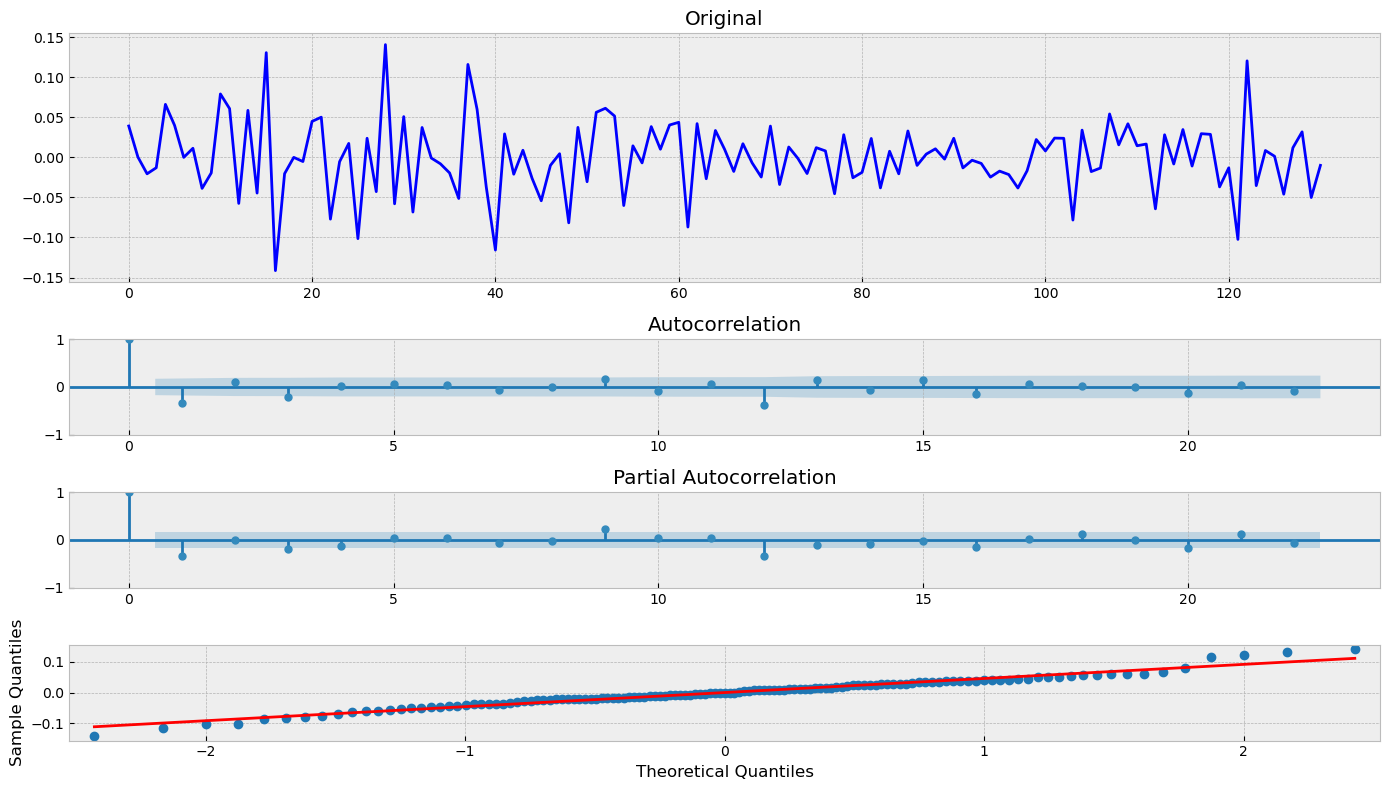

In [24]:
# анализ остатков
tsplot(res.resid)

In [25]:
forecast = res.forecast(horizon=50)
# предсказание с горизонтом = 50

In [26]:
forecast.residual_variance.iloc[-1]

h.01    0.001660
h.02    0.001655
h.03    0.001650
h.04    0.001645
h.05    0.001640
h.06    0.001635
h.07    0.001630
h.08    0.001625
h.09    0.001621
h.10    0.001616
h.11    0.001612
h.12    0.001608
h.13    0.001604
h.14    0.001600
h.15    0.001596
h.16    0.001592
h.17    0.001588
h.18    0.001585
h.19    0.001581
h.20    0.001578
h.21    0.001575
h.22    0.001571
h.23    0.001568
h.24    0.001565
h.25    0.001562
h.26    0.001559
h.27    0.001556
h.28    0.001554
h.29    0.001551
h.30    0.001548
h.31    0.001546
h.32    0.001543
h.33    0.001541
h.34    0.001538
h.35    0.001536
h.36    0.001534
h.37    0.001532
h.38    0.001530
h.39    0.001527
h.40    0.001525
h.41    0.001523
h.42    0.001522
h.43    0.001520
h.44    0.001518
h.45    0.001516
h.46    0.001514
h.47    0.001513
h.48    0.001511
h.49    0.001509
h.50    0.001508
Name: 130, dtype: float64

[0.00166047 0.00165505 0.00164977 0.00164462 0.0016396  0.00163471
 0.00162994 0.00162529 0.00162077 0.00161636 0.00161206 0.00160787
 0.00160379 0.00159981 0.00159593 0.00159215 0.00158847 0.00158488
 0.00158139 0.00157798 0.00157466 0.00157142 0.00156827 0.0015652
 0.0015622  0.00155928 0.00155644 0.00155367 0.00155097 0.00154833
 0.00154577 0.00154327 0.00154083 0.00153846 0.00153614 0.00153389
 0.00153169 0.00152955 0.00152747 0.00152543 0.00152345 0.00152152
 0.00151964 0.0015178  0.00151602 0.00151428 0.00151258 0.00151092
 0.00150931 0.00150774]


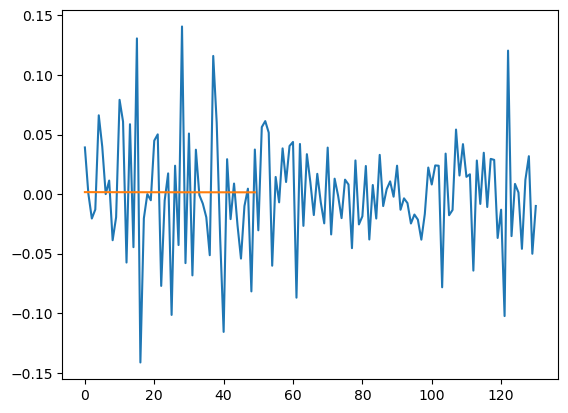

In [27]:
plt.plot(int_air_pass)
print(forecast.residual_variance.iloc[-1].values)
plt.plot([0]*50 + forecast.residual_variance.iloc[-1].values)